In [1]:
import sklearn

from sklearn.datasets import make_circles

#Make 1000 samples
n_sample = 1000

# Cretae circles
X, y = make_circles(n_sample,
                     noise=0.03,
                     random_state=42)
len(X), len(y)


(1000, 1000)

In [2]:
X.dtype

dtype('float64')

In [3]:
#first 10 samples
X[:10], y[:10]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [4]:
# Make Dataframe of circle Data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                      "X2" : X[:,1],
                      "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


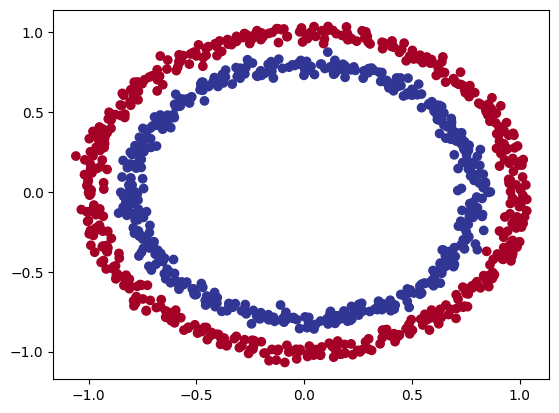

In [5]:

import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
           y= X[:,1],
           c=y,
           cmap = plt.cm.RdYlBu)

In [6]:
# Note the data wer are working with often referred to toy dataset. A dataset that is small enough for do experimentation.

### Check input and output shape

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# view the first sample with label
X_sample = X[0]
y_sample = y[0]

print(f"Value for one sample of x: {X_sample} and the same for y : {y_sample}")
print(f"Shape for one sample of x: {X_sample.shape} and the same for y : {y_sample.shape}")

Value for one sample of x: [0.75424625 0.23148074] and the same for y : 1
Shape for one sample of x: (2,) and the same for y : ()


#### turn data into tensors and creat Traing and Test Split

In [9]:
import torch
torch.__version__

'1.13.1'

In [10]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [11]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [12]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,  # 0.2 = 20%
                                                   random_state=42)

In [14]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [15]:
import torch
from torch import nn

## Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create Liner layer to handle features
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.layer2(self.layer1(x))  # x-> leyer1(x)-> layer2() -> output

model_0 = CircleModelV0().to(device)
model_0
        

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
### lets replicate the same Model using nn.Sequential
model_1 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                       nn.Linear(in_features=5, out_features=1))
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Make predictions with model
model_1.state_dict()


OrderedDict([('0.weight',
              tensor([[ 0.1418,  0.6508],
                      [-0.4519,  0.0674],
                      [-0.3256, -0.5499],
                      [-0.1411,  0.0386],
                      [ 0.2470,  0.1178]])),
             ('0.bias', tensor([ 0.1937,  0.4898,  0.3190, -0.4388, -0.2676])),
             ('1.weight',
              tensor([[-0.0216,  0.0922, -0.3294,  0.4174,  0.0232]])),
             ('1.bias', tensor([-0.3750]))])

In [19]:
# with torch.inference_mode():
#     untrained_preds = model_0(X_test)
#     print(f"first 10 prediction : {untrained_preds[:10]}, {y_test[:10]}")

In [20]:
### Setup Loss function and Optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [21]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))* 100
    return acc

In [22]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds[:10]
y_preds = torch.round(torch.sigmoid(model_0(X_test)[:5]))
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [23]:
#Train model
torch.manual_seed(42)

#no of epochs
epochs = 200
repeatPrintAfterEpochs = 40

#Put data in target deivce
#X_train,y_train = X_train.to(device)

for epoch in range(epochs):
    #  Training loop
    model_0.train()
    
    # 1. Fwd pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    
    # 2. calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_preds)
    # 3. zero grad
    optimizer.zero_grad()

    #4. backpropogation of loss 
    loss.backward()
    
    # 5. Optimizer step SDG
    optimizer.step()
    
    #6 Testing
    model_0.eval()
    with torch.inference_mode():
        
        # 2. fwd pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. calculate test loss/acc
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
        #. print some information
        if epoch % repeatPrintAfterEpochs == 0:
            print(f"# {epoch} | Loss : {loss:.5f} acc : {acc:.2f}% | test_loss : {test_loss:.5f} test acc = {test_acc:.2f}% ")
            


# 0 | Loss : 0.76971 acc : 50.00% | test_loss : 0.76766 test acc = 50.00% 
# 40 | Loss : 0.74525 acc : 50.00% | test_loss : 0.74372 test acc = 50.00% 
# 80 | Loss : 0.72708 acc : 50.00% | test_loss : 0.72648 test acc = 50.00% 
# 120 | Loss : 0.71404 acc : 50.00% | test_loss : 0.71456 test acc = 50.00% 
# 160 | Loss : 0.70506 acc : 50.00% | test_loss : 0.70645 test acc = 50.00% 


In [24]:
#Visualize visualize  visualize !


import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
    


helper_functions.py already exists, skipping download


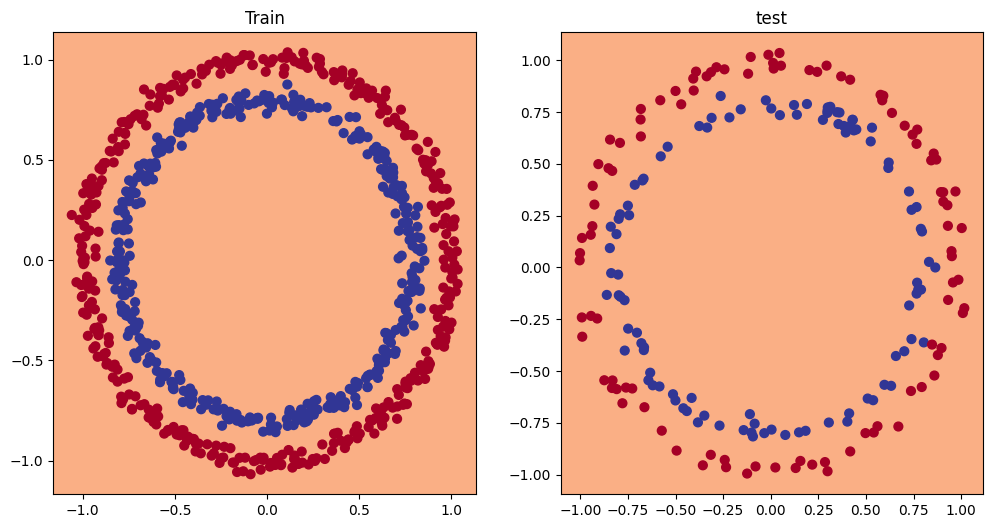

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,X_test,y_test)

In [27]:
# Experimentation
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self,x):
        return self.layer3(self.layer2(self.layer1(x)))

In [31]:
model_1 = CircleModelV1()

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [35]:
# Training and Testoing loop
torch.manual_seed(42)

epochs = 200
epochs_to_skip_before_print = 10

for epoch in range(epochs):
    ##training
    model_1.train()
    
    # 1 fwd pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2.loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. zero grad
    optimizer.zero_grad()
    
    # 4. loss backword
    loss.backward()
    
    # 5. optimizer step
    optimizer.step()
    
    #Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. fwd pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. calculate loss
        
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true= y_test, y_pred=test_pred)
        
        #Print
        if epoch % epochs_to_skip_before_print == 0:
            print(f"# {epoch} | Loss : {loss:.5f} acc : {acc:.2f}% | test_loss : {test_loss:.5f} test acc = {test_acc:.2f}% ")
        

# 0 | Loss : 0.69685 acc : 51.50% | test_loss : 0.69468 test acc = 55.00% 
# 10 | Loss : 0.69435 acc : 50.38% | test_loss : 0.69406 test acc = 50.50% 
# 20 | Loss : 0.69360 acc : 49.88% | test_loss : 0.69430 test acc = 46.50% 
# 30 | Loss : 0.69317 acc : 48.75% | test_loss : 0.69421 test acc = 49.00% 
# 40 | Loss : 0.69302 acc : 51.25% | test_loss : 0.69430 test acc = 47.00% 
# 50 | Loss : 0.69298 acc : 51.75% | test_loss : 0.69460 test acc = 46.00% 
# 60 | Loss : 0.69298 acc : 51.38% | test_loss : 0.69480 test acc = 46.00% 
# 70 | Loss : 0.69298 acc : 51.00% | test_loss : 0.69479 test acc = 46.50% 
# 80 | Loss : 0.69298 acc : 51.12% | test_loss : 0.69472 test acc = 46.50% 
# 90 | Loss : 0.69298 acc : 51.38% | test_loss : 0.69469 test acc = 44.50% 
# 100 | Loss : 0.69298 acc : 51.12% | test_loss : 0.69468 test acc = 45.50% 
# 110 | Loss : 0.69298 acc : 51.25% | test_loss : 0.69467 test acc = 45.50% 
# 120 | Loss : 0.69298 acc : 51.25% | test_loss : 0.69467 test acc = 46.00% 
# 130 | Lo

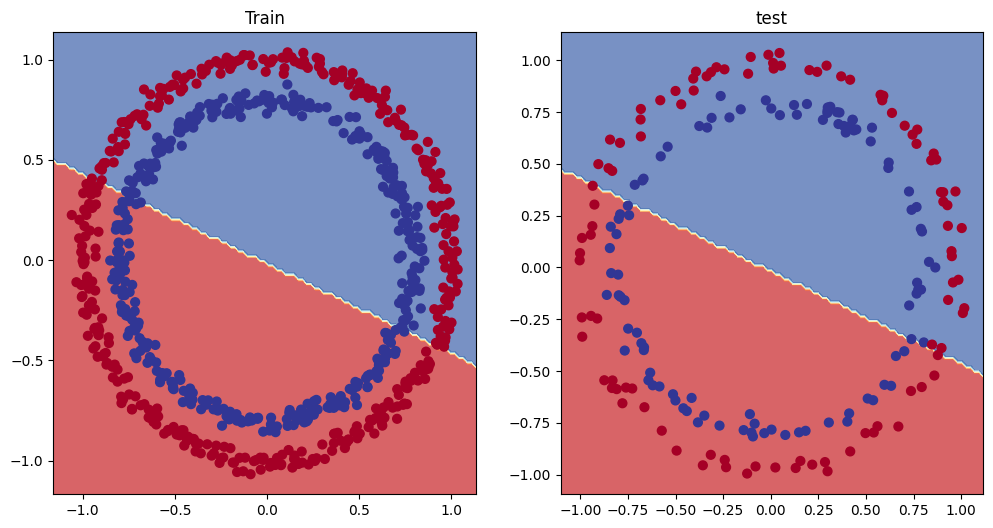

In [36]:
#Plot the decison boundry
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1,X_test,y_test)